# CS585 Lab 3
Problems adpated from **Ex 4.1: Data fitting** in _Richard Szeliski. Computer Vision: Algorithms and Applications, 2nd ed_. In this lab, we'll implement and evaluate scattered data interpolation techniques using radial basis functions.

## Fourier Analysis

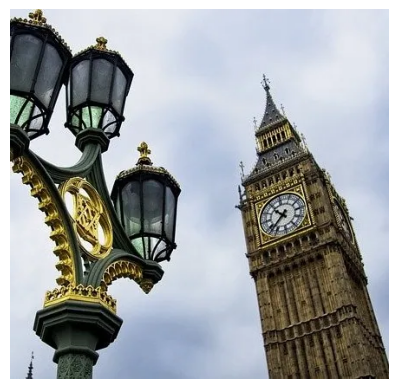

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('Elizabeth_Tower_London.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

The 1d Fourier Transform is 

$$  X_k = \sum_{n=0}^{N-1} x_n e^{-j 2\pi k n / N}, \quad k = 0, 1, …, N-1 $$

$sin(\frac{2\pi x}{\text{wavelength}})$

In [8]:
def fourier_transform_1d(signal):
  """
    Compute the Discrete Fourier Transform of an input signal.
    :param : signal: the input signal, which is a 1D numpy array.
    :return : transform: the Fourier transform of the input signal, which is a 1D numpy array.
  """
  N = len(signal)
  transform = np.zeros(N, dtype=np.complex64)
  for k in range(N):
    for n in range(N):
      angle = (2 * np.pi * k * n) / N
      transform[k] += signal[n] * np.exp(-1j * angle)

  return transform

/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


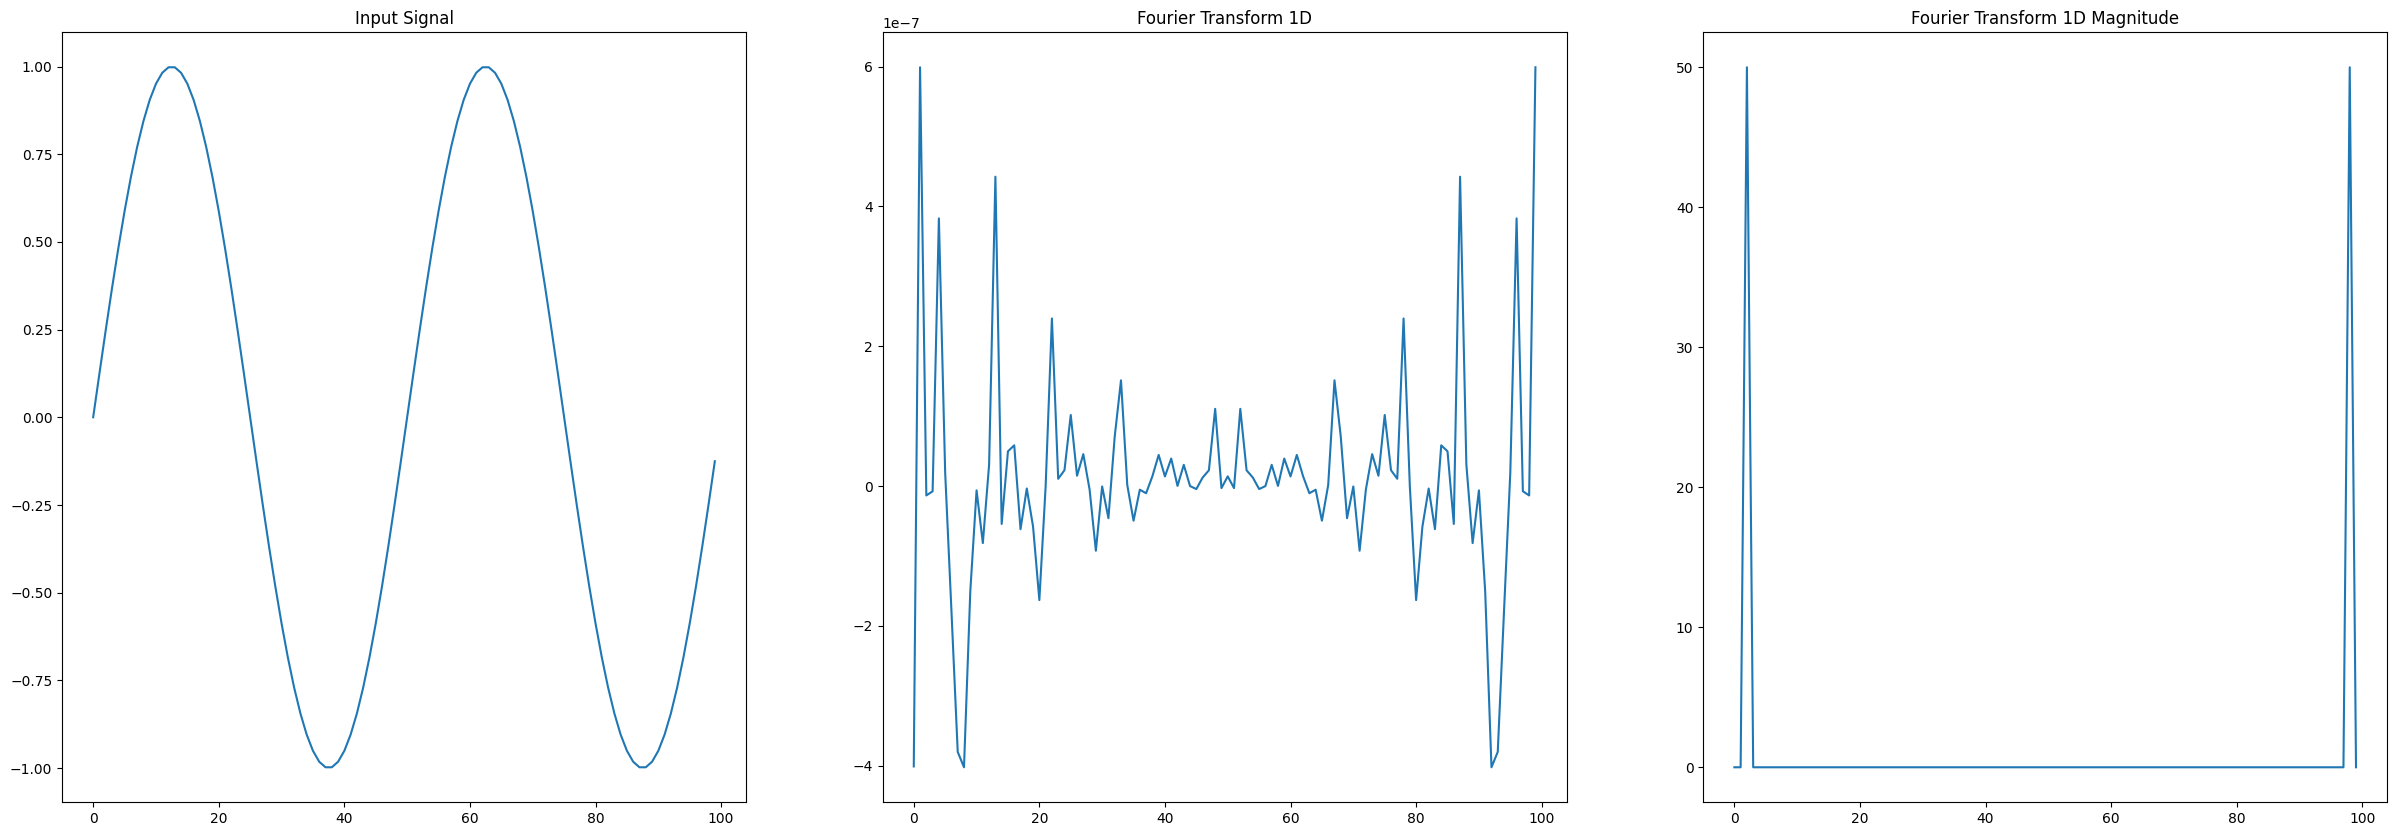

In [9]:
# input signal
wavelength = 50
X = np.arange(100)
signal = np.sin(2 * np.pi * X / wavelength)
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(signal)
plt.title("Input Signal")


transform_1d = fourier_transform_1d(signal)
plt.subplot(132)
plt.plot(transform_1d)
plt.title("Fourier Transform 1D")
plt.subplot(133)
plt.plot(np.abs(transform_1d))
plt.title("Fourier Transform 1D Magnitude")
plt.show()

In [10]:
def fourier_transform_2d(img):
    ft = np.fft.ifftshift(img)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)
def inverse_fourier_transform_2d(img):
    ift = np.fft.ifftshift(img)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

The sinusoidal grating follows the formula : 

$$ I(x, y) = \frac{1}{2} + \frac{1}{2}\cos(\frac{2\pi}{\lambda}(x^{'} + y^{'}))$$

$$ x^{'} = x \cdot \cos(\theta) + y \cdot \sin(\theta)$$

$$ y^{'} = -x \cdot \sin(\theta) + y \cdot \cos(\theta)$$

$$\lambda = \text{wavelength}, \theta = \text{angle}$$

In [12]:
def generate_sinusoidal_grating(height, width, wavelength, angle):
  """
    Generate a sinusoidal grating.
    :param : wavelength: the wavelength of the grating, which is a float.
    :param : angle: the angle of the grating, which is a float.
    :return : grating: the generated grating, which is a 2D numpy array.
  """
  
  x = np.arange(width)
  y = np.arange(height)
  X, Y = np.meshgrid(x, y)

  grating = np.sin(
      2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength
  )
  return grating


In [13]:
def show_image_and_ft(img, ft):
  fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [img.shape[1], ft.shape[1]]})

  axes[0].imshow(img, cmap='gray')
  axes[0].set_title("Input Image")
  axes[0].axis('off')

  axes[1].imshow(ft, cmap='gray')
  axes[1].set_title("Fourier Transform")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()

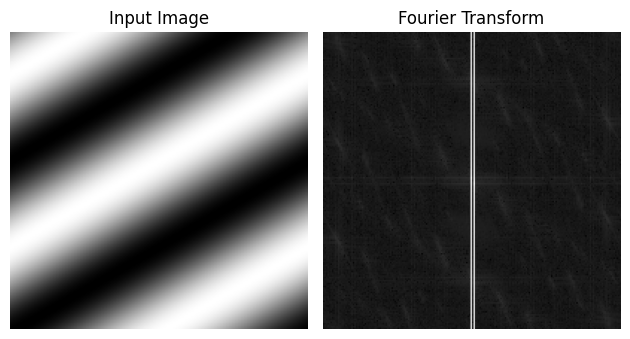

In [14]:
# Display the grating and its fourier transform
grating = generate_sinusoidal_grating(200, 200, wavelength=100, angle=np.pi/3)
ft = fourier_transform_2d(grating)
magnitude_spectrum = np.log(abs(ft))
show_image_and_ft(grating, magnitude_spectrum)

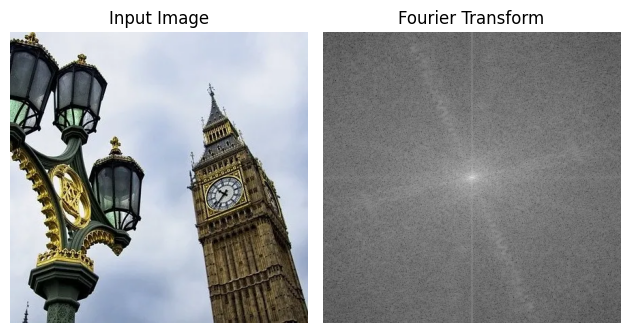

In [15]:
imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ft = fourier_transform_2d(imgGray)
magnitude_spectrum = np.log(abs(ft))

show_image_and_ft(img, magnitude_spectrum)

Text(0.5, 1.0, 'Reconstructed Image')

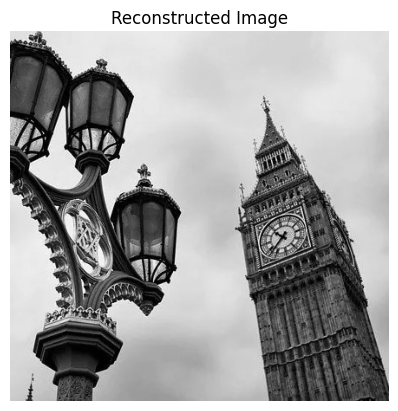

In [16]:
# Reconstruct image
ift = inverse_fourier_transform_2d(ft)
plt.axis('off')
plt.imshow(ift, cmap='gray')
plt.title("Reconstructed Image")

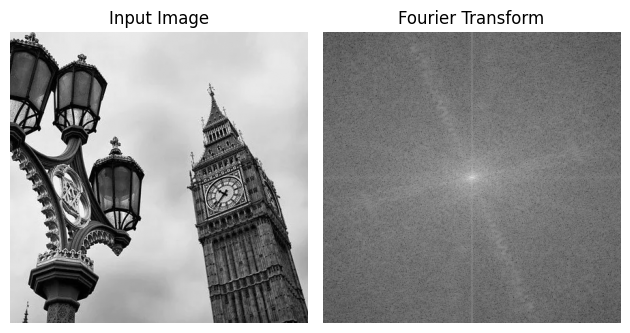

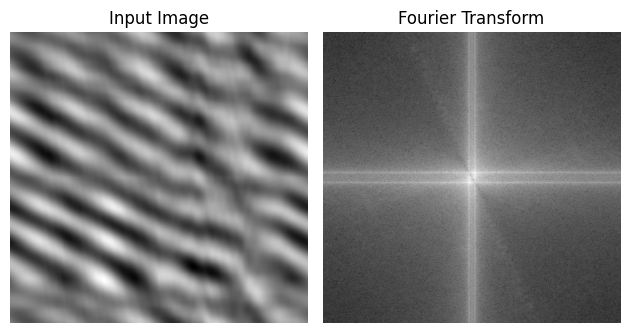

In [17]:
def apply_sinusoidal_mask_ft(img, wavelength, angle):
  """
    Apply a sinusoidal mask to an input image.
    :param : img: the input image, which is a 2D numpy array.
    :param : wavelength: the wavelength of the grating, which is a float.
    :param : angle: the angle of the grating, which is a float.

  """
  height, width = img.shape
  mask = generate_sinusoidal_grating(height, width, wavelength, angle)
  # transform the mask into amplitude frequency
  mask_ft = fourier_transform_2d(mask)
  img_ft = fourier_transform_2d(img)
  masked_ft = img_ft * mask_ft
  #change it back to the input signal
  masked_image = inverse_fourier_transform_2d(masked_ft)
  return masked_image


masked_image = apply_sinusoidal_mask_ft(imgGray, wavelength=50, angle=np.pi*2/3)


# Display the results
show_image_and_ft(imgGray, np.log(abs(fourier_transform_2d(imgGray))))
show_image_and_ft(masked_image, np.log(abs(fourier_transform_2d(masked_image))))


## Basis functions and fitting

In [18]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

def generate_random_samples(low:int,high:int,size:int)->np.array:
    """
     Generate random (x,y) samples from a sine function y=sin(x)+cos(2.5*x+1).
     : param: low: lowest value to be drawn from the sine function, which is a float.
     : param: high: highest value to be drawn from the sine function, which is a float.
     : param: size: number of the generated samples, which is a int.

     :return: samples: the generated samples, which is a [size]x2 array.
    """
    x = np.random.uniform(low, high, size)
    y = np.sin(x) + np.cos(2.5 * x + 1)
    samples = np.stack([x, y], axis=1)
    return samples

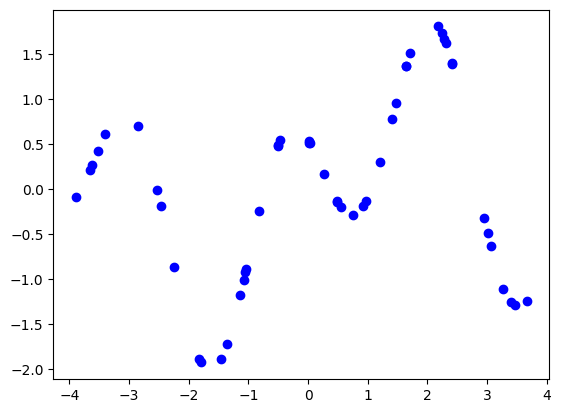

In [19]:
samples=generate_random_samples(-4,4,50)
plt.scatter(samples[:,0],samples[:,1],c='blue')

In [20]:
def basis_function(r:np.array,c:float,method='Guassian')->np.array:
    """
       Compute the value of a basis function f, given its input r and parameter c.
       :param: r: input to the basis function, which is a 1D numpy array.
       :param: c: parameter c in Guassian/Hardy multiquadric/Inverse multiquadric basis function, which is a float.
       :param: name: name of the basis function, which is a string.

       :return: result: value of f(r), which has the same shape as r.
    """
    epsilon=1e-10
    if method=='Guassian':
         result=np.exp(-np.power(r,2)/(epsilon+np.power(c,2)))
    elif method=='Hardy multiquadric':
         result=-np.sqrt(np.power(r,2)+np.power(c,2))
    elif method=='Inverse multiquadric':
         result=1/(epsilon+np.sqrt(np.power(r,2)+np.power(c,2)))
    elif method=='TPS':
        result=np.power(r,2)*np.log(r+epsilon)
    else:
       result=NotImplemented
       
    return result

In [21]:
dist_to_x0=np.sqrt(np.power(samples[0,0]-samples[:,0],2))
radial=basis_function(dist_to_x0,0.6,method='Guassian')
print(radial)

[1.00000000e+00 4.84284796e-15 2.08819372e-05 5.92957808e-28
 1.83813471e-27 3.10830413e-01 2.77266300e-01 1.72863466e-29
 4.21156412e-46 6.82595103e-37 7.32517536e-03 4.03085971e-08
 2.06556254e-19 1.06639304e-21 3.41666746e-03 2.80995056e-11
 3.20094304e-08 3.63566497e-03 8.12935479e-27 1.32342688e-37
 4.78016183e-03 1.34258218e-14 9.09103416e-02 3.73957546e-03
 3.43209045e-43 4.70806424e-17 5.41598035e-04 2.90389146e-28
 6.13064693e-02 1.12460557e-11 3.54645615e-36 2.39153596e-05
 1.62830346e-29 6.66717389e-01 5.03202106e-21 4.74648062e-21
 8.76138840e-01 3.00345998e-42 1.41413582e-05 1.65969586e-40
 4.57751028e-02 9.90744058e-01 2.48521658e-02 9.14688253e-19
 2.84567580e-13 9.56100163e-10 2.01543937e-02 2.72377673e-11
 3.36105711e-02 3.24245297e-08]


In [22]:
def radial_basis_fitting(samples:np.array,param_c:float,method='Guassian')->np.array:
    """
      Fitting the sample data by manually speficying a basis function and the parameter c in this function.
      :param: samples: the sample data, which is a numpy array.
      :param: param_c: the parameter c in the basic function, which is a float.
      :param: method: name of specified the basic function, which is a string.

      :return: predict_ys: the predicted y of the sample data, which is a 1D numpy array.
    """
    predict_ys=[]
    for sample in samples:
        xs=samples[:,0]
        ys=samples[:,1]
        x=sample[0]
        r=np.sqrt(np.power(x-xs,2)) #N
        phi=basis_function(r,param_c,method=method)
        nmlzd_phi=phi/(np.sum(phi)+1e-10)
        predict_y=np.sum(ys*nmlzd_phi)
        predict_ys.append(predict_y)

    predict_ys=np.array(predict_ys)

    return predict_ys


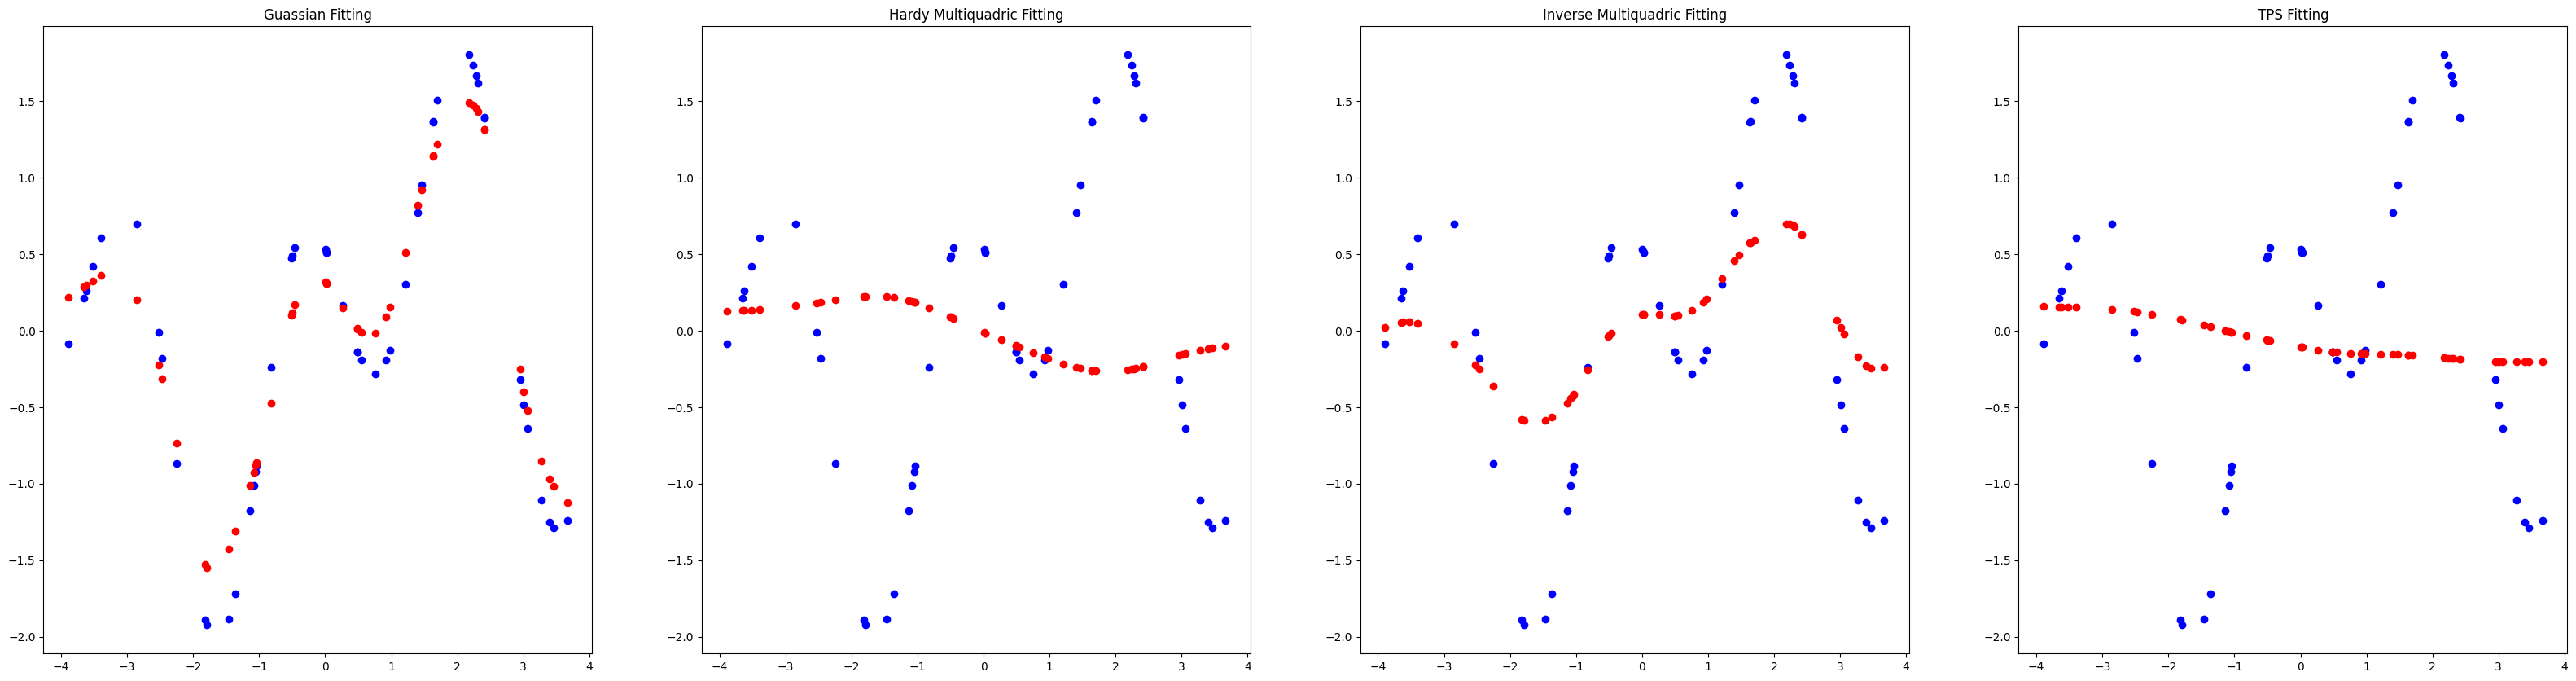

In [23]:
param_c=0.5
p_ys=radial_basis_fitting(samples,param_c,method='Guassian')
plt.figure(figsize=(40,10))
plt.subplot(141)
plt.title('Guassian Fitting')
plt.scatter(samples[:,0],samples[:,1],c='blue')
plt.scatter(samples[:,0],p_ys,c='red')

param_c=0.2
p_ys=radial_basis_fitting(samples,param_c,method='Hardy multiquadric')
plt.subplot(142)
plt.title('Hardy Multiquadric Fitting')
plt.scatter(samples[:,0],samples[:,1],c='blue')
plt.scatter(samples[:,0],p_ys,c='red')

param_c=0.3
p_ys=radial_basis_fitting(samples,param_c,method='Inverse multiquadric')
plt.subplot(143)
plt.title('Inverse Multiquadric Fitting')
plt.scatter(samples[:,0],samples[:,1],c='blue')
plt.scatter(samples[:,0],p_ys,c='red')

p_ys=radial_basis_fitting(samples,param_c,method='TPS')
plt.subplot(144)
plt.title('TPS Fitting')
plt.scatter(samples[:,0],samples[:,1],c='blue')
plt.scatter(samples[:,0],p_ys,c='red')
